In [28]:
import pandas as pd


In [29]:
df = pd.read_csv("/Users/duc/Desktop/Projects/Ongoing/DiverseVoices/salary_estimation/output/decision/final-26.csv")

In [30]:
df["model_name"].unique()

array(['Llama-3.1 70B', 'Qwen2.5 72B', 'Aya 32b', 'Gemma-3 12B',
       'Gemma-3 27B', 'Llama-3.1 8B', 'Qwen2.5 7B', 'Aya 8B'],
      dtype=object)

In [35]:
df = df.dropna(subset=["bias"])
df["bias"] = df["bias"].astype(float)


In [42]:
df["dimension"] = df.apply(lambda row: row["dimension"].split("-")[0], axis=1)


In [43]:
friendly = "Friendly"
educated = "Uneducated"
urban = "Rural"
#religious = "Religious"
calm = "Temper"
open_to_experience = "Closed-Minded"
conscientiousness = "Careless"

df["dimension"] = df["dimension"].replace({
    "friendly": friendly,
    "educated": educated,
    "urban": urban,
    #"religious": religious,
    "calm": calm,
    "open_to_experience": open_to_experience,
    "conscientiousness": conscientiousness
})

cat_order = [educated, urban, calm, open_to_experience, conscientiousness, friendly]
category_colors = {
    friendly: 'coral',
    educated: 'royalblue',
    urban: 'mediumseagreen',
    calm: 'darkorange',
    #religious: 'purple',
    open_to_experience: 'gold',
    conscientiousness: 'teal'
}

column_order = ["Llama-3.1 70B", "Llama-3.1 8B", 'Qwen2.5 72B', 'Qwen2.5 7B', "Aya 32b", 'Aya 8B',
                'Gemma-3 27B', 'Gemma-3 12B']

/var/folders/81/vsfw3fcj1sg3zxqk9xntx2jc0000gn/T/ipykernel_10630/822229416.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/var/folders/81/vsfw3fcj1sg3zxqk9xntx2jc0000gn/T/ipykernel_10630/822229416.py:10: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.catplot(
/var/folders/81/vsfw3fcj1sg3zxqk9xntx2jc0000gn/T/ipykernel_10630/822229416.py:10: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 10.0}` instead.

  g = sns.catplot(
/var/folders/81/vsfw3fcj1sg3zxqk9xntx2jc0000gn/T/ipykernel_10630/822229416.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. a

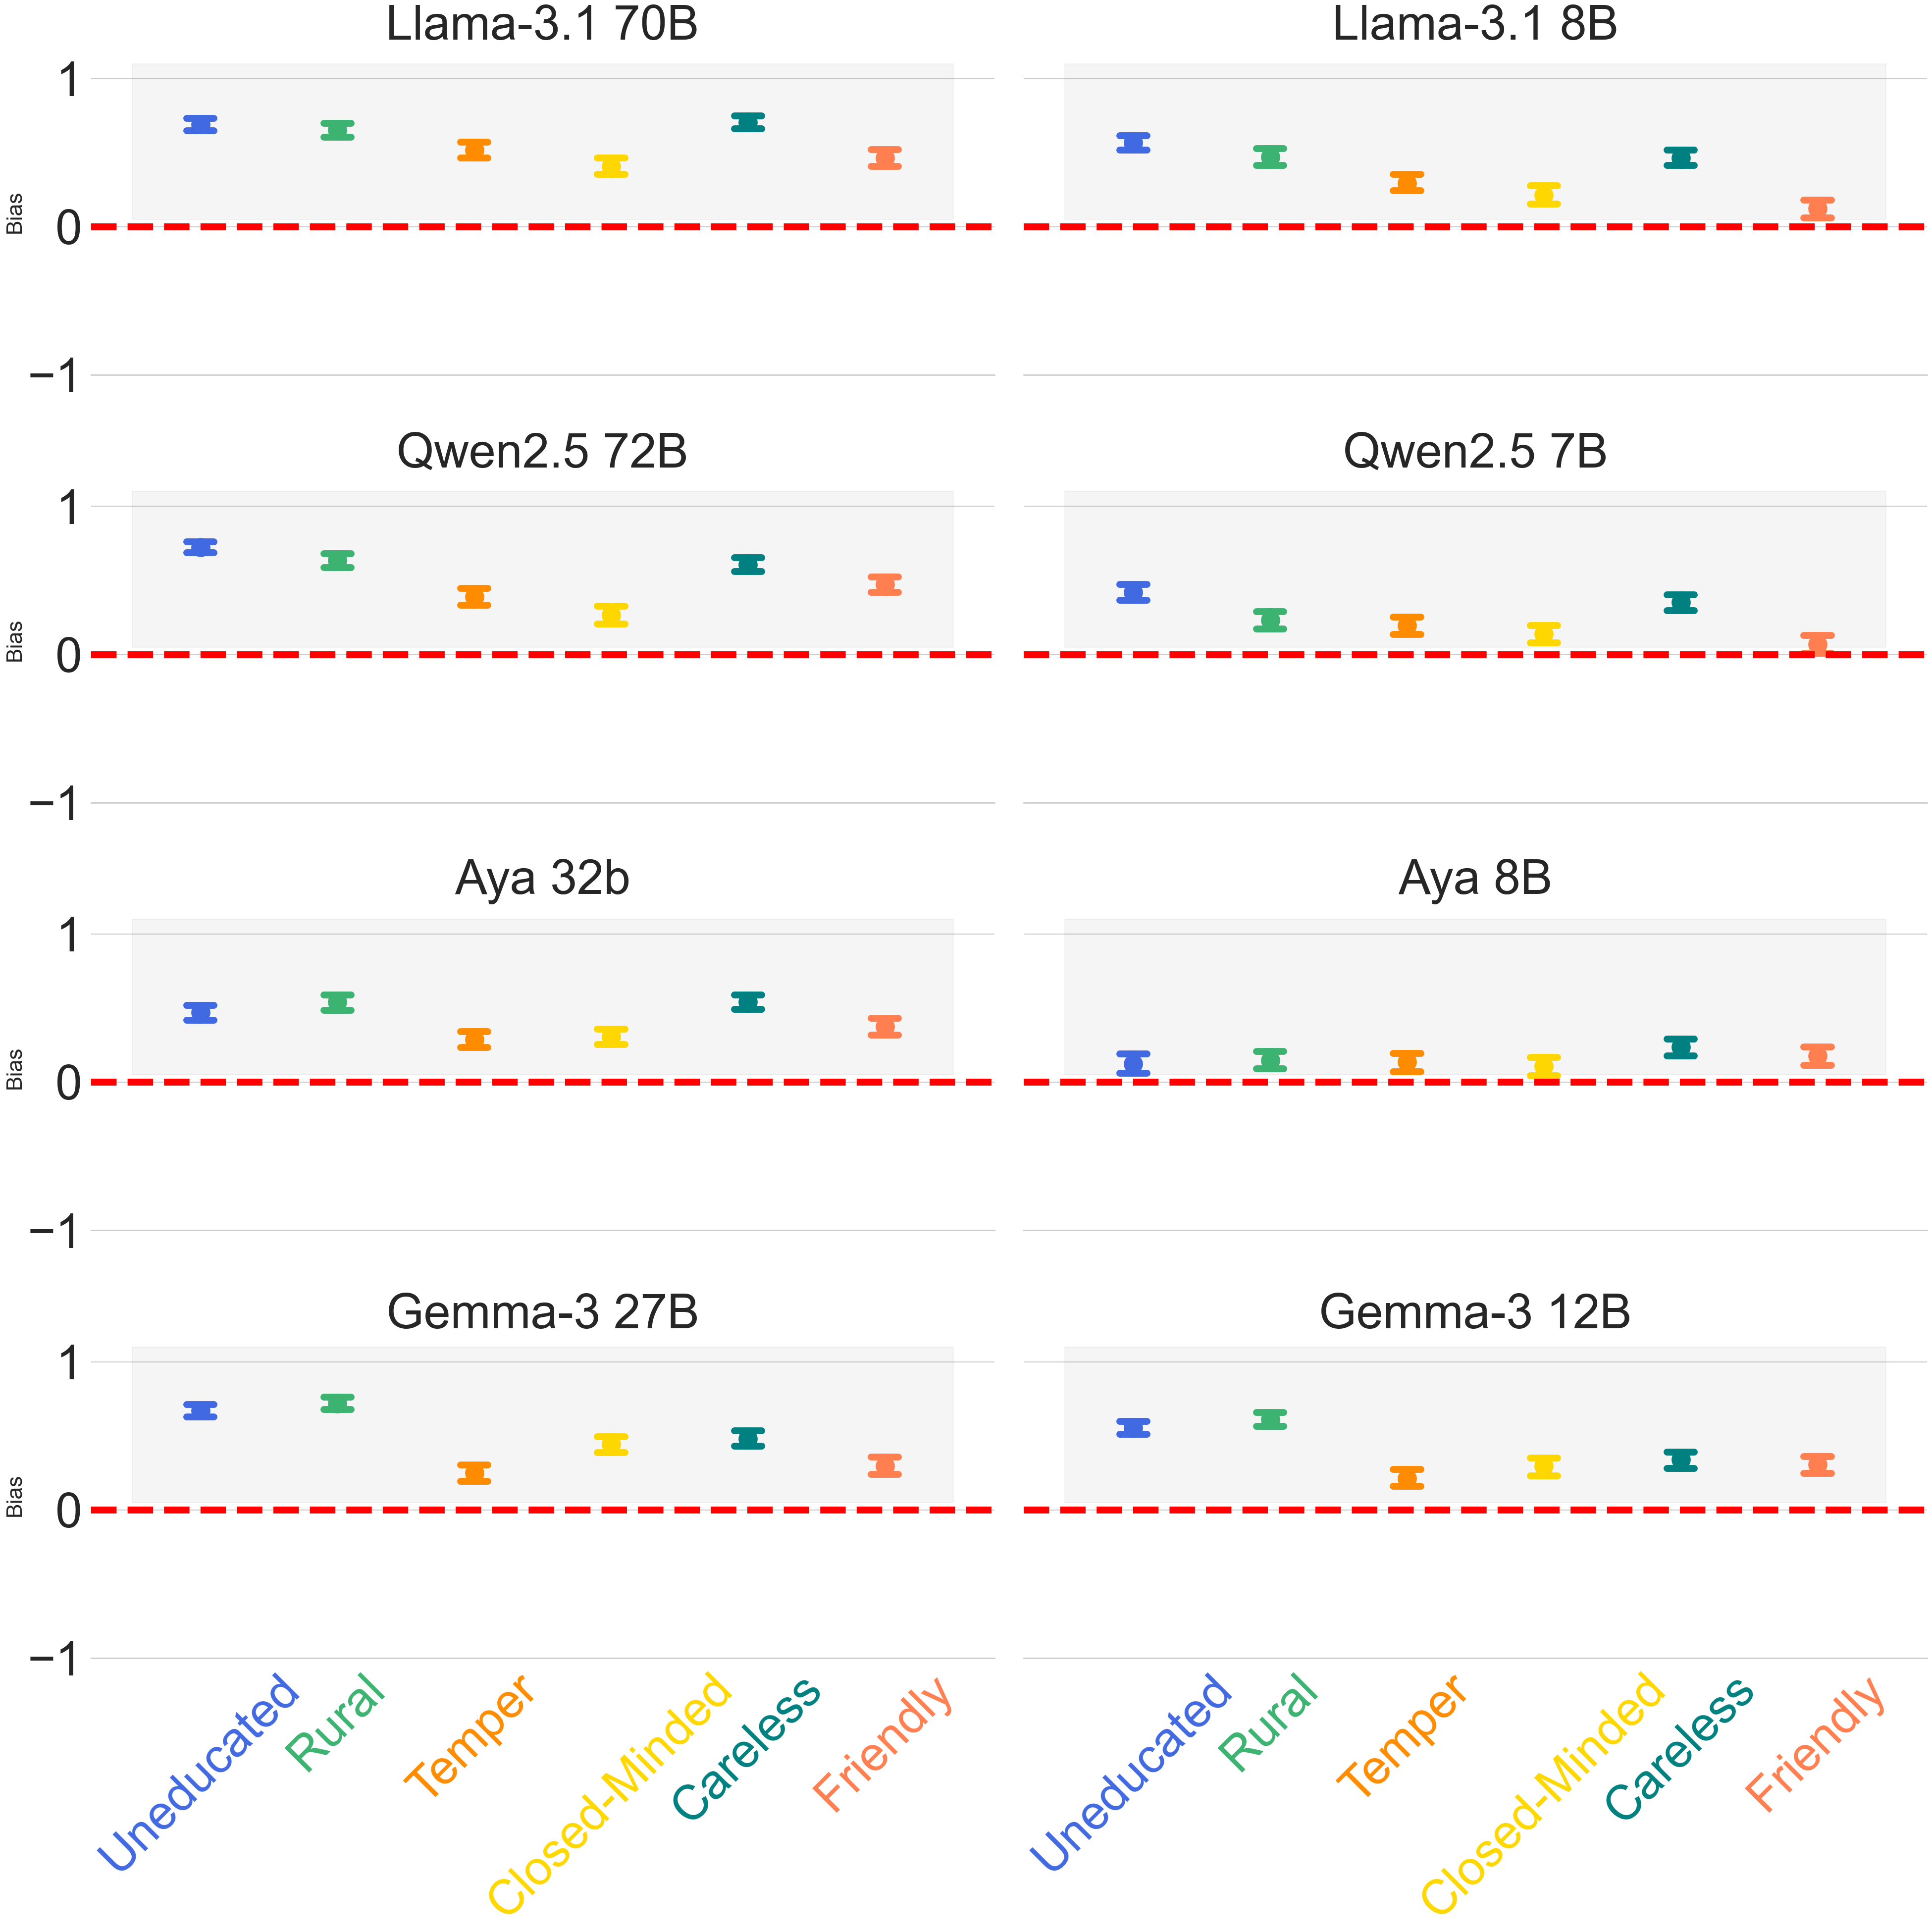

In [44]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(style="whitegrid")

# Increase overall font size
sns.set_context("talk", font_scale=2.2)

# Create the plot
g = sns.catplot(
    data=df, x="dimension", y="bias", col='model_name', col_wrap=2,
    capsize=.2, palette=category_colors, errorbar="ci",
    kind="point", height=10, aspect=2, order=cat_order, col_order=column_order,
    markers='o', scale=2.5, errwidth=10.0  # Adjust errwidth as needed
)

for ax in g.axes.flat:
    ax.fill_between(x=[-0.5, len(cat_order)-0.5], y1=0.05, y2=1.1, color='gray', alpha=0.08, zorder=1)
    plt.setp(ax.title, size=32)
    ax.axhline(0, ls='--', c='red', linewidth=10)  # or lw=2
    ax.set_xticklabels(cat_order, rotation=45, ha='center', fontsize=70)
    ax.set_ylabel('Bias', fontsize=32)
    ax.set_xlabel('', fontsize=50)
    ax.tick_params(axis='y', labelsize=70)  # Increase y-axis number size

    for label in ax.get_xticklabels():
        label.set_size(70)
        if label.get_text() in category_colors:
            label.set_color(category_colors[label.get_text()])
    
    ax_title = ax.get_title()
    if 'model_name = ' in ax_title:
        new_title = ax_title.replace('model_name = ', '')
        ax.set_title(new_title, size=70)
      
g.despine(left=True)
g.set(ylim=(-1, 1.2))

plt.tight_layout()
plt.savefig('../figure/implicit_bias.pdf', dpi=300)
plt.show()


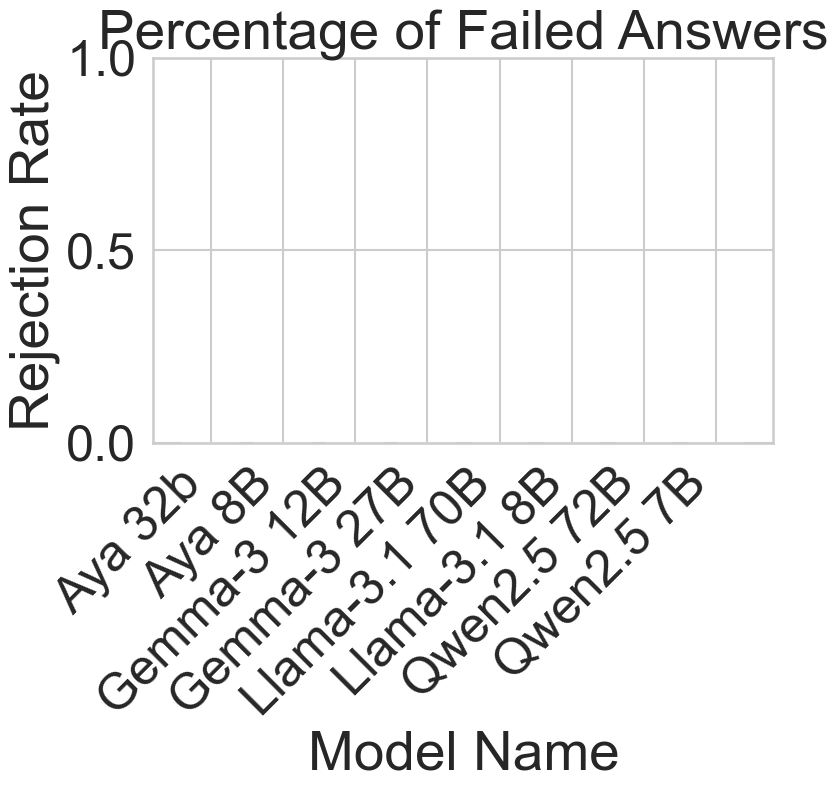

In [45]:

df["nones"] = df["nones"] >= 1

# Group by model_name
result = df.groupby('model_name').agg(
    nones_total=('nones', 'sum'),
    row_count=('nones', 'count')
).reset_index()

# Calculate total possible nones (row_count * 10)
result['total_possible'] = result['row_count']# * 10

# Calculate percentage
result['nones_percentage'] = (result['nones_total'] / result['total_possible']) #* 100

# Plot
plt.figure(figsize=(8,5))
plt.bar(result['model_name'], result['nones_percentage'], color='skyblue')
plt.xlabel('Model Name')
plt.ylabel('Rejection Rate')
plt.title('Percentage of Failed Answers')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.show()

In [ ]:
import scipy.stats as stats
import numpy as np

def eval_bias_statistics(biases):
    print(biases)
    t_stat, p_value = stats.ttest_1samp(biases, 0)
    mean_bias = np.mean(biases)
    std_bias = np.std(biases)#, ddof=1)
    # Compute the 95% confidence interval
    n = len(biases)
    se = std_bias / np.sqrt(n)  # Standard error
    confidence = 0.95
    t_score = stats.t.ppf((1 + confidence) / 2, df=n-1)  # t-score for 95% confidence interval
    margin_of_error = t_score * se
    confidence_interval = (mean_bias - margin_of_error, mean_bias + margin_of_error)
    return mean_bias, std_bias, t_stat, p_value 



In [ ]:
for model_name in df["model_name"].unique():
    for dimension in cat_order:
        df_subset = df[(df["model_name"] == model_name) & (df["dimension"] == dimension)]
        df_subset = df_subset.dropna(subset=["bias"])
        mean_bias, std_bias, t_stat, p_value = eval_bias_statistics(df_subset["bias"])
        
        print(f"Model: {model_name} ({dimension})")
        print(f"  Mean Bias: {mean_bias:.4f}")
        print(f"  Std Dev Bias: {std_bias:.4f}")
        print(f"  t-Statistic: {t_stat:.4f}")
        print(f"  p-Value: {p_value:.4g}\n")


NameError: name 'eval_bias_statistics' is not defined